In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

## Load In the Data

In [2]:
skin_df = pd.read_csv("hmnist_64_64_RBG.csv")

In [4]:
skin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,196,192,149,192,194,...,186,154,180,186,156,183,183,152,174,2
1,24,13,23,24,14,27,37,24,46,61,...,25,15,29,27,15,27,25,14,24,2
2,185,129,140,192,136,151,198,143,157,199,...,152,120,138,144,113,122,120,90,93,2
3,23,11,19,36,19,30,64,38,50,91,...,27,12,16,25,12,16,23,9,13,2
4,140,95,118,158,113,139,178,133,160,191,...,141,106,118,107,76,91,77,49,63,2


In [5]:
X = skin_df.drop("label", axis=1).to_numpy()
label = skin_df["label"].values

In [6]:
X.shape, label.shape

((10015, 12288), (10015,))

In [7]:
def plotImg(img):
    plt.imshow(img)
    plt.title("Skin Cancer Image")
    plt.grid(False)
    plt.axis("off")
    plt.show()

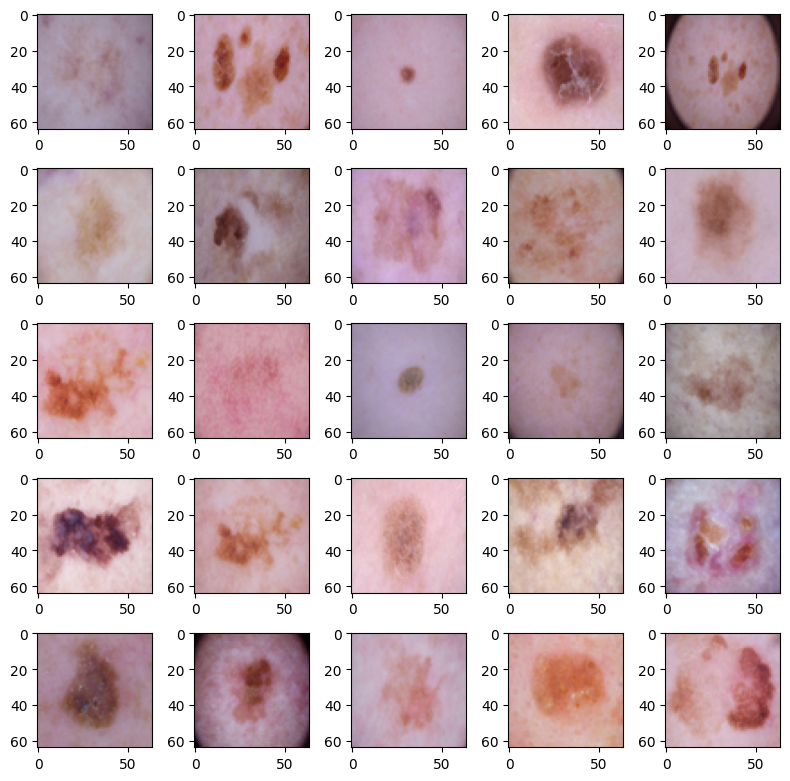

In [8]:
fig, axes = plt.subplots(5,5)
fig.set_size_inches(8, 8)
for i in range(5):
    for j in range(5):
        n = np.random.randint(0,1000, 1)
        axes[i,j].imshow(X[n].reshape(64,64,3))
    plt.tight_layout()

## Scaling and Split Data into Train, Validation and Test set

In [9]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [10]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [11]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

In [13]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7210, 12288), (1803, 12288), (7210,), (1803,))

## Reshape the Data to Input in CNN

In [14]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

In [15]:
X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [16]:
y_train.shape

(7210,)

In [17]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [18]:
y_train.shape, y_val.shape, y_test.shape

((7210, 7), (1803, 7), (1002, 7))

## CNN Model

In [19]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(7, activation='softmax')(x)
model = Model(img_input, output)


In [20]:
# Configure and compile the model
import tensorflow.keras as keras
model.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496 

## Define Data Generator for Data Augmentation and Learning Rate Adaptive Reduction to Prevent Overfitting

In [22]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.00001)

In [24]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\janar\AppData\Local\Temp\ipykernel_1892\3666111815.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30


112/112 [==============================] - 10s 75ms/step - loss: 0.9883 - accuracy: 0.6579 - val_loss: 0.8894 - val_accuracy: 0.6911 - lr: 0.0010
Epoch 2/30
112/112 [==============================] - 8s 73ms/step - loss: 0.8628 - accuracy: 0.6860 - val_loss: 0.7964 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/30
112/112 [==============================] - 8s 73ms/step - loss: 0.7997 - accuracy: 0.7024 - val_loss: 0.7682 - val_accuracy: 0.7022 - lr: 0.0010
Epoch 4/30
112/112 [==============================] - 8s 74ms/step - loss: 0.7710 - accuracy: 0.7145 - val_loss: 0.7501 - val_accuracy: 0.7227 - lr: 0.0010
Epoch 5/30
112/112 [==============================] - 8s 73ms/step - loss: 0.7408 - accuracy: 0.7261 - val_loss: 0.7551 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 6/30
112/112 [==============================] - 8s 73ms/step - loss: 0.7281 - accuracy: 0.7275 - val_loss: 0.7209 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 7/30
112/112 [==============================] - 8s 73ms

In [27]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))


57/57 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.7654
Validation: accuracy = 0.765391  ;  loss_v = 0.638060
Test: accuracy = 0.756487  ;  loss = 0.698674


In [29]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

57/57 [==============================] - 0s 7ms/step
Classification report for classifier <keras.src.engine.functional.Functional object at 0x000002EC30DF8090>:
              precision    recall  f1-score   support

     class 0       0.51      0.45      0.48        58
     class 1       0.65      0.54      0.59        94
     class 2       0.51      0.53      0.52       197
     class 3       0.60      0.14      0.23        21
     class 4       0.89      0.88      0.88      1209
     class 5       0.93      0.74      0.82        34
     class 6       0.44      0.54      0.48       190

    accuracy                           0.77      1803
   macro avg       0.65      0.55      0.57      1803
weighted avg       0.77      0.77      0.77      1803




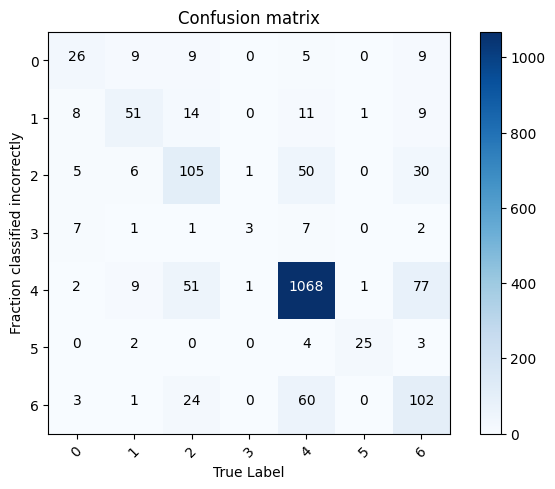

In [30]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

#lesion_type_dict = {
 #   'akiec': 'Actinic_keratoses',
 #   'bcc': 'Basal_cell_carcinoma',
 #  'bkl': 'Benign_keratosis-like_lesions',
 #  'df': 'Dermatofibroma',
 # 'nv': 'Melanocytic_nevi',
 # 'vasc': 'Vascular_lesions',
 #'mel': 'melanoma'}

Text(0.5, 1.0, 'Training and validation loss')

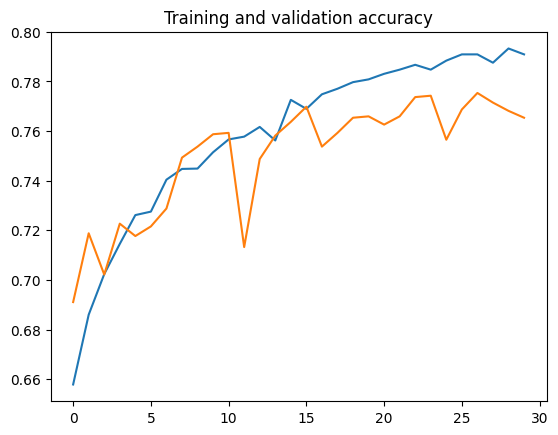

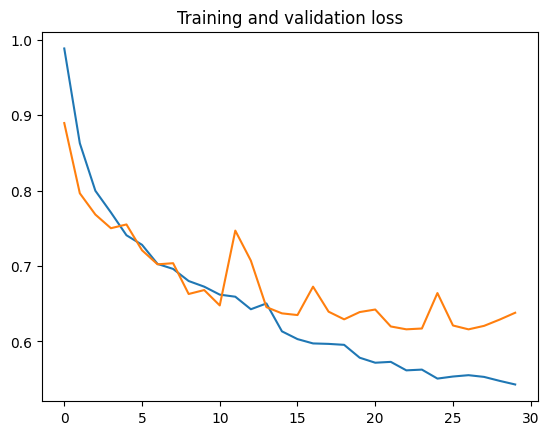

In [31]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [32]:
model.save("Baseline_CNN.h5")

C:\Users\janar\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
